### Example to show how to simulate detections from point reference with given uncertainty.

In [1]:
import numpy as np
import uncertainties
from uncertainties import ufloat
import matplotlib.pyplot as plt
from scipy.stats import chi2, kstest, norm

from radardetseval.utilities.ecdf import ecdf
from radardetseval.simulators.sim_det_from_point import sim_det_from_scs_cart_point
from radardetseval.unc_prop.u_cart_state_to_polar_state import u_cart_state_to_polar_state
from radardetseval.stats.nees import nees_test
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.visualization.plot_point import plot_point
from radardetseval.visualization.utilities import publish_reduced_labels

### Inputs definition

Firstly, define parameters of reference position, velocity and corresponding uncertainty. It is assumed that postion uncertainty is not correlated and has the same magnitude in both directions. Similary for velocity.

In [2]:
ref_x = 10.0
ref_y = 3.0
ref_vx = 1.0
ref_vy = -3.0

ref_pos_std = 0.05
ref_vel_std = 0.1

Secondly parametrs of sensor need to be defined. Automotive radar sensors have relativly better range than azimuth accuracy. Most likely the most accurate measurment is range rate

In [3]:
range_std = 0.2
azimuth_std = np.deg2rad(0.3)
range_rate_std = 0.06

The last part of input definition is number of montle carlo simulation samples

In [4]:
N_samples = 10000

Simuation input parameters needs to be proceed to more simulation friendly format

In [5]:
ref_cov = np.power(np.diag([ref_pos_std, ref_pos_std, ref_vel_std, ref_vel_std]), 2.0)
meas_cov = np.power(np.diag([range_std, azimuth_std, range_rate_std]), 2.0)
ref_state_cart = np.array([ref_x, ref_y, ref_vx, ref_vy])

### Simuation - single sample

In [6]:
sim_out = sim_det_from_scs_cart_point(ref_state_cart, ref_cov, meas_cov, 1)

Text(0.5, 1.0, 'Simulation of reference and measurement data from ground truth')

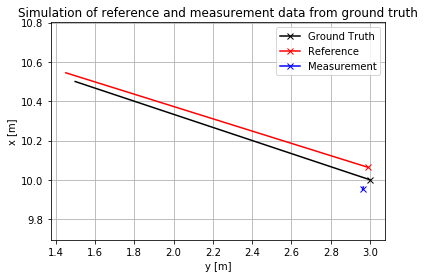

In [7]:
fig, ax = plt.subplots()
v_scale = 0.5
plot_point(ax, sim_out.ref_x, sim_out.ref_y, sim_out.ref_vx, sim_out.ref_vy, v_scale=v_scale, 
           color='k', label='Ground Truth')
plot_point(ax, sim_out.signals.sim_ref_x, sim_out.signals.sim_ref_y, 
           sim_out.signals.sim_ref_vx, sim_out.signals.sim_ref_vy, 
           v_scale=v_scale, color='r', label='Reference')
plot_detection_scs(ax, sim_out.signals.sim_meas_range, sim_out.signals.sim_meas_range_rate, sim_out.signals.sim_meas_azimuth, 
                   rr_scale=v_scale, color='b', label='Measurement')
publish_reduced_labels(ax)
ax.set_xlabel('y [m]')
ax.set_ylabel('x [m]')
ax.axis('equal')

ax.grid()
ax.set_title('Simulation of reference and measurement data from ground truth')


### Simulation - Monte Carlo

In [8]:
sim_out = sim_det_from_scs_cart_point(ref_state_cart, ref_cov, meas_cov, N_samples)

### Evaluation

Calculating deviation values

In [9]:
sim_out.signals['deviation_range'] = sim_out.signals.sim_ref_range - sim_out.signals.sim_meas_range
sim_out.signals['deviation_azimuth'] = sim_out.signals.sim_ref_azimuth - sim_out.signals.sim_meas_azimuth
sim_out.signals['deviation_range_rate'] = sim_out.signals.sim_ref_range_rate - sim_out.signals.sim_meas_range_rate

Defining Normalized Estimated Error Square (NEES) function for this problem

In [10]:
def nees_function(row, ness_cov_inv):
    deviation = np.array([row['deviation_range'], row['deviation_azimuth'], row['deviation_range_rate']])
    nees = (deviation.transpose() @ ness_cov_inv) @ deviation
    return nees

Defining NEES covaraince matrix which is constant for this simation. Reference and estimated data comes from two different distribution with common mean and different covaraince matrix. Moreover uncertainty of reference data is defined in cartesian system and measurement in polar. To calculate NEES value reference uncertainty needs to be converted into polar uncertainties. It is done by linear aproximation of nonlinear functions.

In [11]:
u_ref_x = ufloat(ref_x, ref_pos_std)
u_ref_y = ufloat(ref_y, ref_pos_std)
u_ref_vx = ufloat(ref_vx, ref_vel_std)
u_ref_vy = ufloat(ref_vy, ref_vel_std)

u_range, u_azimuth, u_range_rate, u_cross_radial_vel = u_cart_state_to_polar_state(u_ref_x,
                                                                           u_ref_y,
                                                                           u_ref_vx,
                                                                           u_ref_vy)

ref_cov_pol = np.array(uncertainties.covariance_matrix([u_range, u_azimuth, u_range_rate]))
ref_corr_pol = uncertainties.correlation_matrix([u_range, u_azimuth, u_range_rate])

nees_cov = ref_cov_pol + meas_cov
ness_cov_inv_value = np.linalg.inv(nees_cov)
print(f'Correlation matrix \n {ref_corr_pol}')

Correlation matrix 
 [[ 1.00000000e+00  0.00000000e+00 -5.35994779e-18]
 [ 0.00000000e+00  1.00000000e+00 -1.49671023e-01]
 [-5.35994779e-18 -1.49671023e-01  1.00000000e+00]]


Claculating NEES values

In [12]:
sim_out.signals['nees_values'] = sim_out.signals.apply(nees_function, axis=1, args=[ness_cov_inv_value])

## Distributions of results when measured and refernce covaraince was taken into account

Configuration

In [13]:
x_ref = np.linspace(0,20,1000)
y_ref = chi2.pdf(x_ref, 3) # 3 variables so 3 degree of freedom
N_bins = 100

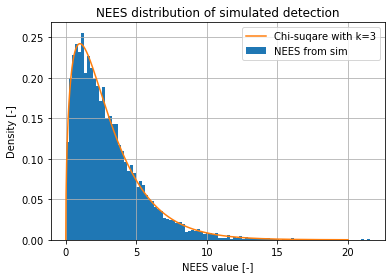

In [14]:
sim_out.signals['nees_values'].hist(bins=100, density=True, label='NEES from sim')
plt.plot(x_ref, y_ref, label='Chi-suqare with k=3')
plt.xlabel('NEES value [-]')
plt.ylabel('Density [-]')
plt.title('NEES distribution of simulated detection')
plt.legend()

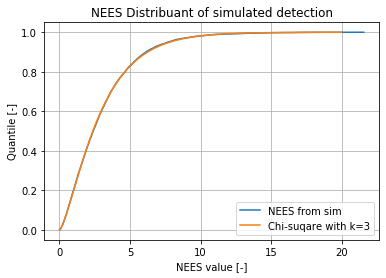

In [15]:
x_ecdf, y_ecdf = ecdf(sim_out.signals['nees_values'])
y_ref_cdf = chi2.cdf(x_ref, 3)
plt.plot(x_ecdf, y_ecdf, label='NEES from sim')
plt.plot(x_ref, y_ref_cdf, label='Chi-suqare with k=3')
plt.xlabel('NEES value [-]')
plt.ylabel('Quantile [-]')
plt.title('NEES Distribuant of simulated detection')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Difference bitween empirical and reference distribuant')

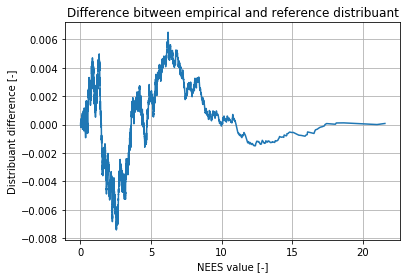

In [16]:
y_ref_ecdf = chi2.cdf(x_ecdf, 3)
ecdf_diff = y_ecdf - y_ref_ecdf
plt.plot(x_ecdf, ecdf_diff)
plt.xlabel('NEES value [-]')
plt.ylabel('Distribuant difference [-]')
plt.grid()
plt.title('Difference bitween empirical and reference distribuant')

Text(0.5, 1.0, 'Anderson-Darling weight')

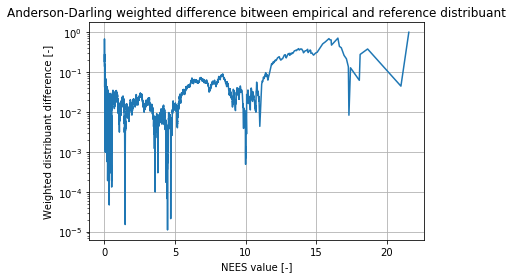

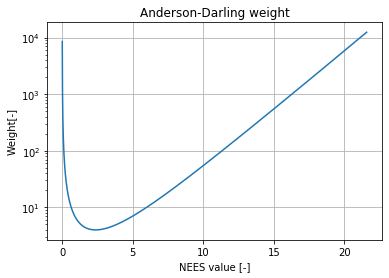

In [17]:
a2_weight = 1/(y_ref_ecdf * (1-y_ref_ecdf))
ecdf_diff_a2_weight = ecdf_diff * a2_weight
plt.figure()
plt.semilogy(x_ecdf, abs(ecdf_diff_a2_weight))
plt.xlabel('NEES value [-]')
plt.ylabel('Weighted distribuant difference [-]')
plt.grid()
plt.title('Anderson-Darling weighted difference bitween empirical and reference distribuant')

plt.figure()
plt.semilogy(x_ecdf, a2_weight)
plt.xlabel('NEES value [-]')
plt.ylabel('Weight[-]')
plt.grid()
plt.title('Anderson-Darling weight')

## Statistical tests

Kolmogorov–Smirnov goodnes of fit test

In [18]:
max_d, p_value_ks = kstest(sim_out.signals['nees_values'], 'chi2', tuple([3]))
print(f'Maximum distance between empirical and reference distribution is {max_d:.3f}')
print(f'Kolmogorov–Smirnov test p_value is {p_value_ks:.3f}')

Maximum distance between empirical and reference distribution is 0.008
Kolmogorov–Smirnov test p_value is 0.623


NEES test

In [19]:
nees_mean = sim_out.signals['nees_values'].mean()
nees_test_variable, p_value_nees_test = nees_test(sim_out.signals['nees_values'], 3)
print(f'NEES mean is {nees_mean:.3f}')
print(f'NEES test Z varaible is {nees_test_variable:.3f}')
print(f'NEES test p_value is {p_value_nees_test:.3f}')


NEES mean is 2.996
NEES test Z varaible is 2.996
NEES test p_value is 0.873
